# **Chapter 16**  
**┗ 이상 유저 감지**
---
> **목차(Context)**

* 문제상황 및 데이터 살펴보기
* 문제해결 프로세스 정의
* 🥉Session 1 - 「데이터 전처리 및 EDA」
* 🥈Session 2 - 「가설 수립 및 검증, 인사이트 발굴」
* 🥇Session 3 - 「이상 탐지 모델링」

In [1]:
location = 'colab' # ▶ local에서 내려받아 실행시 'local', Colab에서 실행시 'colab'

In [ ]:
import warnings
import os
warnings.filterwarnings('ignore') # ▶ Warnings 제거

if location == 'colab' :    
    from google.colab import drive
    drive.mount('/content/drive') # ▶ Google drive mount or 폴더 클릭 후 구글드라이브 연결
    notebook_path = '//content/drive/MyDrive/Colab Notebooks/00.Fast_campus/02.Anomaly_detection/03.Part3/Chapter11' # ▶ 노트북 파일이 존재하는 경로 입력
    os.chdir(notebook_path)

Mounted at /content/drive


# **문제상황 및 데이터 살펴보기**
---
> **시나리오** 🧑💗 (이커머스 개발자/데이터분석가)
```
A회사는 비정상적인 거래/결제 기록에 대한 데이터베이스(e.g. 사고 기록 등)를 보유하고 있고
이를 바탕으로 미래에 일어나는 비정상적인 거래/결제를 탐지하고 사고가 일어나기 전에 사전에 탐지하여 차단하려고 한다
```

> **데이터 살펴보기**

- 데이터로더 작성

* 데이터로더 작성 이유: 객체지향 프로그래밍. 코드의 재사용성, 협업 용이

In [ ]:
from typing import Union
from pathlib import Path
import pandas as pd

class DataLoader:
    def __init__(self, data_path:Union[str, Path]):
        self.data_path = data_path
    def load_transaction_data(self) -> pd.DataFrame:
        return (
            pd.read_csv(self.data_path/'transaction.csv', index_col=0)
        )
    def load_customer_data(self) -> pd.DataFrame:
        return (
            pd.read_csv(self.data_path/'customer.csv', index_col=0)
        )
    
data_path = Path().cwd() / 'Anomaly Detection (FC)' / 'Step 3. 도메인별 이상탐지 실습' / '[01] Chapter 16. 이상 유저 감지'
data_loader = DataLoader(data_path=data_path)

In [ ]:
data_transaction = data_loader.load_transaction_data()
data_customer = data_loader.load_customer_data()

- e-Commerece order/transaction 이해

![](figures/16_1.png)
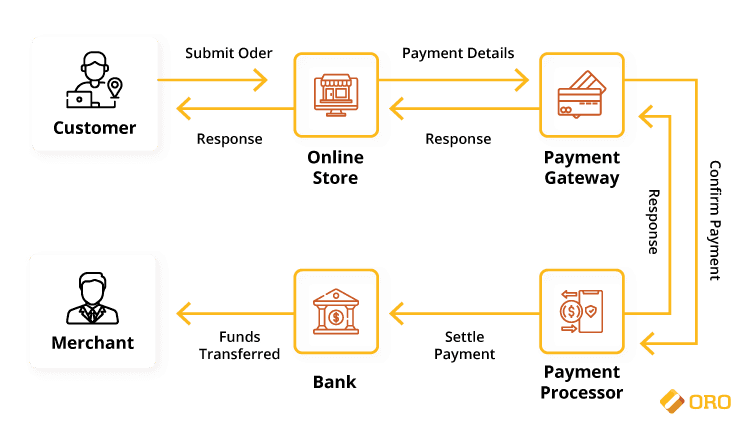

* Transaction data (거래 데이터)
* 데이터 명세 ⬇

In [ ]:
data_description_dict = {
    'customerEmail':'유저 이메일',
    'transactionId':'거래 고유 번호',
    'orderId':'주문 고유 번호',
    'paymentMethodId':'지불수단 아이디',
    'paymentMethodRegistrationFailure':'지불수단 등록 실패',
    'paymentMethodType':'지불수단 방법',
    'paymentMethodProvider':'지불수단 제공자',
    'transactionAmount':'거래 금액',
    'transactionFailed':'거래 실패',
    'orderState':'주문 상태',
}

(
    data_transaction
    .append(
        data_description_dict,
        ignore_index=True
    )
    .iloc[[-1, 0]]
    .T
    .rename(columns={623:'데이터 설명', 0:'샘플 데이터'})
)

,데이터 설명,샘플 데이터
customerEmail,유저 이메일,josephhoward@yahoo.com
transactionId,거래 고유 번호,a9lcj51r
orderId,주문 고유 번호,vjbdvd
paymentMethodId,지불수단 아이디,wt07xm68b
paymentMethodRegistrationFailure,지불수단 등록 실패,1
paymentMethodType,지불수단 방법,card
paymentMethodProvider,지불수단 제공자,JCB 16 digit
transactionAmount,거래 금액,18
transactionFailed,거래 실패,0
orderState,주문 상태,pending


* 주문번호 하나당 거래번호 여러개 존재할 수 있음 (payment가 여러개 발생했을 수 있음)

In [ ]:
data_transaction.groupby('orderId')['transactionId'].count().sort_values().to_frame()

,transactionId
orderId,
00z9c8,1
m6pkzg,1
m1ivme,1
lwn8yr,1
lv7bgj,1
...,...
phfc5z,4
st9dv0,5
v1sq5r,5


> **데이터 살펴보기**

* User data (유저 데이터)
* 비정상적인 거래/결제 사고를 일으켰던 유저에 대한 정보를 `Fraud` 컬럼으로 보유중
* 데이터 명세 ⬇

In [ ]:
data_description_dict = {
    'customerEmail':'유저 이메일',
    'customerPhone':'유저 전화번호',
    'customerDevice':'유저 사용기기',
    'customerIPAddress':'유저 IP',
    'customerBillingAddress':'유저 지불 주소',
    'No_Transactions':'거래 횟수',
    'No_Orders':'주문 횟수',
    'No_Payments':'?',
    'Fraud':'이상 유저'
}

(
    data_customer
    .append(
        data_description_dict,
        ignore_index=True
    )
    .iloc[[-1, 0]]
    .T
    .rename(columns={168:'데이터 설명', 0:'샘플 데이터'})
)

,데이터 설명,샘플 데이터
customerEmail,유저 이메일,josephhoward@yahoo.com
customerPhone,유저 전화번호,400-108-5415
customerDevice,유저 사용기기,yyeiaxpltf82440jnb3v
customerIPAddress,유저 IP,8.129.104.40
customerBillingAddress,유저 지불 주소,"5493 Jones Islands\nBrownside, CA 51896"
No_Transactions,거래 횟수,2
No_Orders,주문 횟수,2
No_Payments,?,1
Fraud,이상 유저,False



# **문제해결 프로세스 정의**
---
> **문제정의**

```
▶ 비정상적 거래를 차단하여 사고로 인한 손실 회피
(결제 취소, 환불 및 피해 보상, 물건 회수 등)
```  

> **기대효과**

```
▶ 거래 사고 관련 피해액 감소
```

> **해결방안**

```
▶ 과거 사고 데이터를 바탕으로 이상 유저/거래 탐지 모델을 개발
▶ Session 1 🥉
 - Data 전처리 및 EDA
▶ Session 2 🥈
 - 가설 수립 및 검증, 인사이트 발굴
▶ Session 3 🥇
 - 이상 탐지 모델링
```

> **성과측정**  

```
▶ 디플로이 이후 기간동안 사고 탐지율을 모니터링하여 모델 성능 및 탐지성과 측정
```

> **현업적용**  

```
▶ Model에 Input하기 위한 Data mart 생성
▶ 예측 모델 활용을 위한 사고 데이터 수집
```


# **🥉Session 1**  
**┗ 데이터 전처리 및 EDA**  
---

### · Data 이해
---
* 수집된 데이터의 기본 정보들을 확인  

#### (1) Data shape(형태) 확인 
- 얼마나 많은 Record(row)가 있는지, 사용할 수 있는 Feature(column)의 수가 얼마나 되는지 확인



In [ ]:
data_transaction.shape

(623, 10)

In [ ]:
data_customer.shape

(168, 9)

#### (2) Data type 확인
- Categorical, numerical feature가 얼마나 있는지 확인

In [ ]:
data_transaction.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 623 entries, 0 to 622
Data columns (total 10 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   customerEmail                     623 non-null    object
 1   transactionId                     623 non-null    object
 2   orderId                           623 non-null    object
 3   paymentMethodId                   623 non-null    object
 4   paymentMethodRegistrationFailure  623 non-null    int64 
 5   paymentMethodType                 623 non-null    object
 6   paymentMethodProvider             623 non-null    object
 7   transactionAmount                 623 non-null    int64 
 8   transactionFailed                 623 non-null    int64 
 9   orderState                        623 non-null    object
dtypes: int64(3), object(7)
memory usage: 53.5+ KB


In [ ]:
data_customer.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 168 entries, 0 to 167
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   customerEmail           168 non-null    object
 1   customerPhone           168 non-null    object
 2   customerDevice          168 non-null    object
 3   customerIPAddress       168 non-null    object
 4   customerBillingAddress  168 non-null    object
 5   No_Transactions         168 non-null    int64 
 6   No_Orders               168 non-null    int64 
 7   No_Payments             168 non-null    int64 
 8   Fraud                   168 non-null    bool  
dtypes: bool(1), int64(3), object(5)
memory usage: 12.0+ KB


#### (3) Null값 확인 (※ 빈 값의 Data)
- 빈 값이 있을 경우 모델에서 Null값을 핸들링해주는지 확인
- 또는 Imputation을 통해 빈 값을 채워주거나
- Imputation이 어려울 경우 해당 Row를 제거하는 방법도 고려하여야 함

In [ ]:
data_transaction.isna()

,customerEmail,transactionId,orderId,paymentMethodId,paymentMethodRegistrationFailure,paymentMethodType,paymentMethodProvider,transactionAmount,transactionFailed,orderState
0,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...
618,False,False,False,False,False,False,False,False,False,False
619,False,False,False,False,False,False,False,False,False,False
620,False,False,False,False,False,False,False,False,False,False
621,False,False,False,False,False,False,False,False,False,False


Text(0.5, 1.0, 'Transaction data')

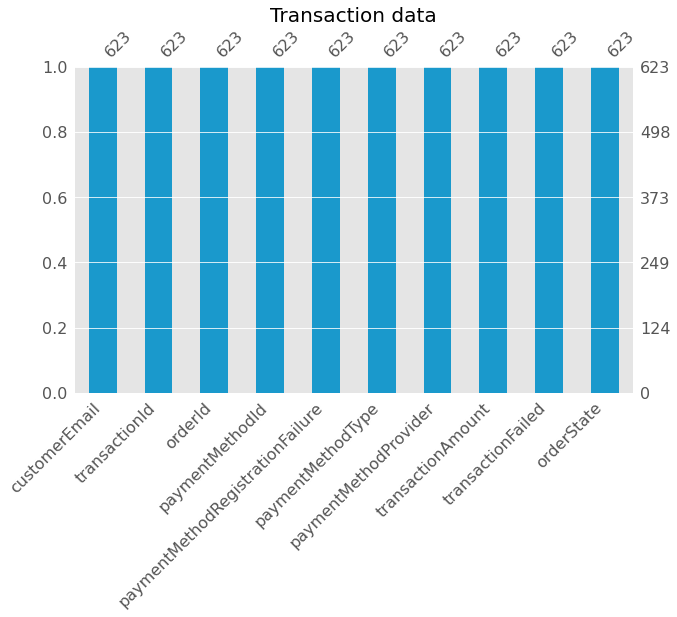

In [ ]:
import matplotlib.pyplot as plt
import missingno as msno
plt.style.use('ggplot')

msno.bar(df=data_transaction, color=(0.1, 0.6, 0.8), figsize=(10, 6))
plt.title('Transaction data', fontsize=20)

* 결측치가 존재하는 경우는 아래와 같이 나옴

Text(0.5, 1.0, 'Transaction data when NA exists')

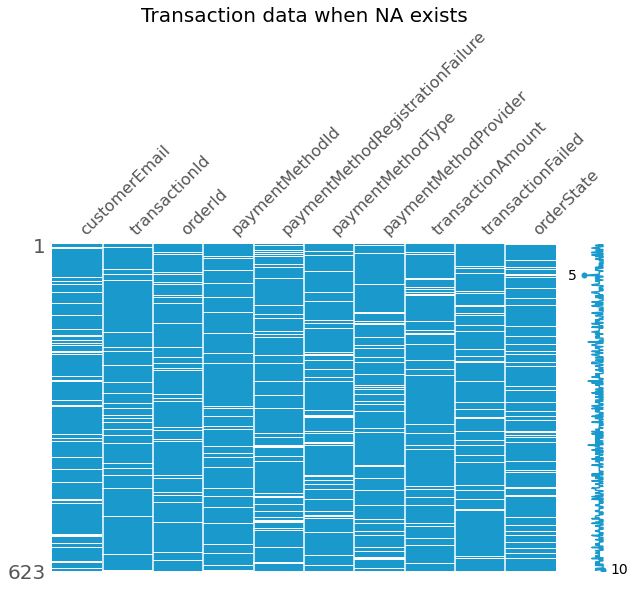

In [ ]:
import numpy as np

data_nan = (
    data_transaction
    .copy()
    .mask(np.random.random(data_transaction.shape) < .1)
)

msno.matrix(df=data_nan, color=(0.1, 0.6, 0.8), figsize=(10, 6))
plt.title('Transaction data when NA exists', fontsize=20)

In [ ]:
data_customer.isna()

,customerEmail,customerPhone,customerDevice,customerIPAddress,customerBillingAddress,No_Transactions,No_Orders,No_Payments,Fraud
0,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...
163,False,False,False,False,False,False,False,False,False
164,False,False,False,False,False,False,False,False,False
165,False,False,False,False,False,False,False,False,False
166,False,False,False,False,False,False,False,False,False


Text(0.5, 1.0, 'Customer data')

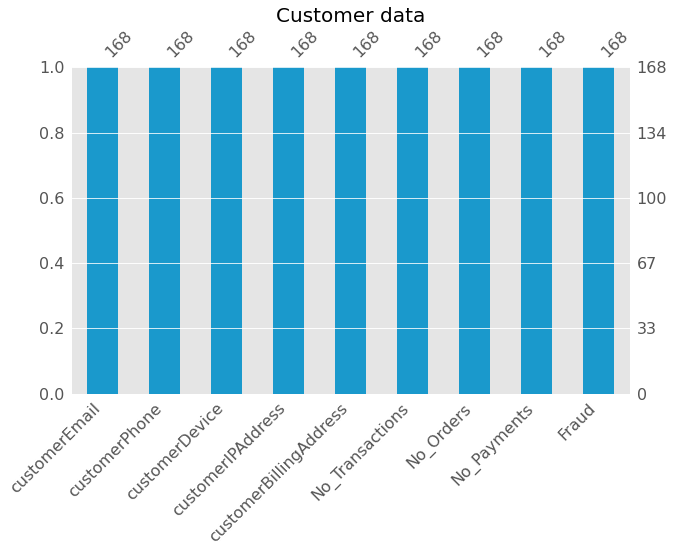

In [ ]:
msno.bar(df=data_customer, color=(0.1, 0.6, 0.8), figsize=(10, 6))
plt.title('Customer data', fontsize=20)

#### (4) # of unique values, data distribution, outlier 확인 (※ 정상적인 범주를 벗어난 Data) 

- number of unique values : 예측에 사용할 수 있는 유의미한 정보를 담은 Column인지, 단순 ID 등의 의미없는 Column인지 확인
- Distribution : 학습에 방해가 될 수 있는 불균형한 데이터셋인지 확인. Label이 Imbalanced한 경우 Novelty dectection 등의 모델을 고려하여야 함
- Outlier 확인 : 모델 학습에 방해가 될 수 있는 Outlier 등이 존재하는지 확인


In [ ]:
(
    data_transaction
    .nunique()
)

customerEmail                       136
transactionId                       623
orderId                             478
paymentMethodId                     237
paymentMethodRegistrationFailure      2
paymentMethodType                     4
paymentMethodProvider                10
transactionAmount                    67
transactionFailed                     2
orderState                            3
dtype: int64

In [ ]:
(
    pd.DataFrame(
        [(column, data_transaction[column].unique().shape[0]) for column in data_transaction.columns], 
        columns=['column_name', 'number_of_unique_values']
    )
)

,column_name,number_of_unique_values
0,customerEmail,136
1,transactionId,623
2,orderId,478
3,paymentMethodId,237
4,paymentMethodRegistrationFailure,2
5,paymentMethodType,4
6,paymentMethodProvider,10
7,transactionAmount,67
8,transactionFailed,2
9,orderState,3


In [ ]:
(
    pd.DataFrame(
        [(column, data_customer[column].unique().shape[0]) for column in data_customer.columns], 
        columns=['column_name', 'number_of_unique_values']
    )
)

,column_name,number_of_unique_values
0,customerEmail,161
1,customerPhone,168
2,customerDevice,168
3,customerIPAddress,165
4,customerBillingAddress,166
5,No_Transactions,13
6,No_Orders,9
7,No_Payments,11
8,Fraud,2


* 라벨 불균형 정도가 심하지 않음

Text(0, 0.5, 'Fraud user')

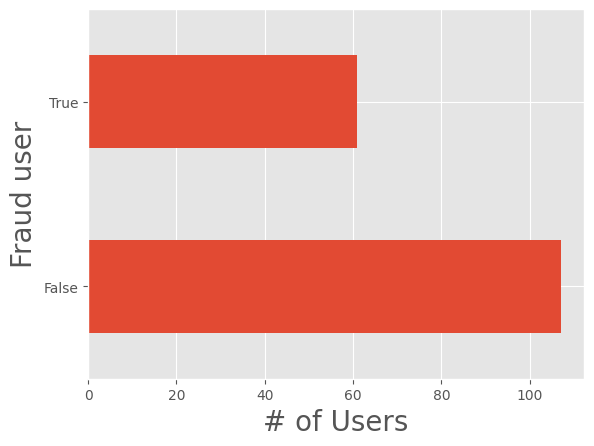

In [ ]:
(
    data_customer['Fraud']
    .value_counts()
    .plot(kind='barh')
)
plt.xlabel('# of Users', fontsize=20)
plt.ylabel('Fraud user', fontsize=20)

* Fraud user가 발생시킨 transaction가 일반 transaction보다 더 많음..!

Text(0, 0.5, 'Fraud transaction')

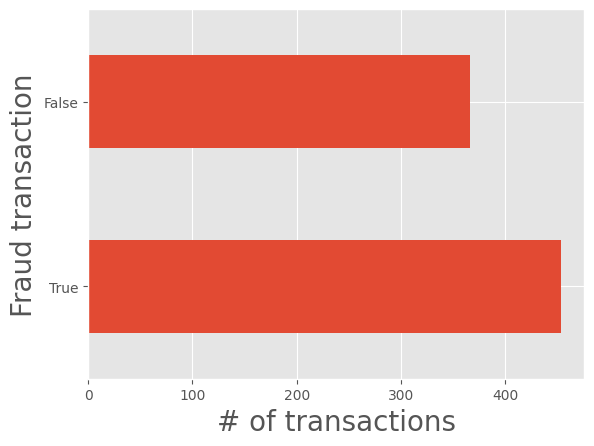

In [ ]:
(
    data_transaction
    .merge(
        data_customer,
        left_on='customerEmail',
        right_on='customerEmail',
        how='left'
    )
    .loc[:, 'Fraud']
    .value_counts()
    .plot(kind='barh')
)
plt.xlabel('# of transactions', fontsize=20)
plt.ylabel('Fraud transaction', fontsize=20)

### · EDA로부터 얻은 인사이트
---
#### (1) 피쳐 수가 적고, 결측치가 없는 데이터셋
#### (2) Novelty detection을 고려해야할만큼 불균형한 데이터셋은 아님

# **🥈Session 2**  
**┗ 가설 수립 및 검증, 인사이트 발굴**  
---

### · 가설 수립
- EDA : 데이터를 보고 떠올리거나
- 문헌조사 : 관련 논문, 업계 리포트, 뉴스 등을 참조하거나
- 인터뷰 : 관련 부서 담당자분들께 아이디어를 얻음
---
#### (1) 동일한 Email/IP/BillingAdress 로 중복 가입한 유저가 있다?
#### (2) Fraud 유저들은 인위적으로 생성된 개인정보를 기입하는지?
#### (3) Fraud는 동일한 계정에서 반복적으로 일어나는 것인지, 개별 계정에서 산발적으로 일어나는 것인지?

### · 가설 검증 및 인사이트 발굴
---

#### (1) 동일한 Email/IP/BillingAdress 로 중복 가입한 유저가 있다?

In [ ]:
data_customer.head()

,customerEmail,customerPhone,customerDevice,customerIPAddress,customerBillingAddress,No_Transactions,No_Orders,No_Payments,Fraud
0,josephhoward@yahoo.com,400-108-5415,yyeiaxpltf82440jnb3v,8.129.104.40,"5493 Jones Islands\nBrownside, CA 51896",2,2,1,False
1,evansjeffery@yahoo.com,1-788-091-7546,r0jpm7xaeqqa3kr6mzum,219.173.211.202,356 Elizabeth Inlet Suite 120\nPort Joshuabury...,3,3,7,True
2,andersonwilliam@yahoo.com,024.420.0375,4m7h5ipl1shyavt6vv2r,67b7:3db8:67e0:3bea:b9d0:90c1:2b60:b9f0,"8478 Sean Ridges Apt. 441\nDavisberg, PR 72250",5,3,2,False
3,rubenjuarez@yahoo.com,670.664.8168x94985,slovx60t0i558may4ks0,95de:8565:5a66:792c:26e0:6cfb:7d87:11af,"7769 Elizabeth Bridge Apt. 343\nNortonstad, FM...",3,3,1,False
4,uchen@malone.com,1-981-877-0870,j0pd24k5h8dl2fqu0cz4,196.89.235.192,"148 Russell Lodge Apt. 445\nPort Jenniferside,...",7,7,6,True


In [ ]:
(
    data_customer
    .groupby(['customerEmail'])
    ['customerPhone'].count()
    .sort_values()
)

customerEmail
1yf0@jedyz63t                1
mtrevino@gutierrez.net       1
mullenstephanie@yahoo.com    1
nancymayo@brown.com          1
natalie98@yahoo.com          1
                            ..
grace99@wright.com           1
gsimpson@cox.org             1
gwilcox@hotmail.com          1
zthomas@gmail.com            1
johnlowery@gmail.com         8
Name: customerPhone, Length: 161, dtype: int64

In [ ]:
(
    data_customer
    .loc[lambda x : x['customerEmail']=='johnlowery@gmail.com'] 
)

# 여기 코드들처럼 ( ) 안에 줄 바꿔 여러 메소드를 연결해 쓰는 것을 'method chaining'이라 함

,customerEmail,customerPhone,customerDevice,customerIPAddress,customerBillingAddress,No_Transactions,No_Orders,No_Payments,Fraud
7,johnlowery@gmail.com,044-642-9860,rjb0adai34izqvys4938,212.144.68.190,"484 Pamela Pass\nLake Jessicaview, WI 12942-9074",6,5,2,True
40,johnlowery@gmail.com,737-377-9701x577,jz66ap43id2y35ivfqa5,6c21:ac1d:2089:68fa:abb7:8c00:525f:6588,"08238 Kyle Squares Suite 893\nMillermouth, IN ...",0,0,1,True
45,johnlowery@gmail.com,+16(4)9016414340,cdx178qymd6vy77nm4x3,222.79.159.140,"77711 Pamela Ridge\nNew Kayla, IL 27182",3,2,1,True
65,johnlowery@gmail.com,04712252182,311kdz4c1210iixltk2j,42b3:df19:86fe:abd9:dafe:f6c1:eb76:c72,"11704 Andrew Villages Apt. 035\nJamesfurt, OR ...",7,5,1,True
79,johnlowery@gmail.com,1-820-539-4726x993,2in0fh7lep289n8dcbdz,163.128.139.42,"814 Wagner Union\nAshleymouth, HI 35617",2,2,1,True
133,johnlowery@gmail.com,1-143-059-1833,tyijaify2hqadwslejyr,e4c:fb48:8ee2:9819:6ae8:8d3f:3b6a:a788,"518 Wood Mews Apt. 970\nDillonstad, NE 43317-3945",0,0,0,True
155,johnlowery@gmail.com,076-099-0630x72770,6qy6oa3nqutsyyxzc54c,f259:657f:f329:2fca:c06c:8b57:d6ac:2380,"687 Rogers Bridge Suite 780\nValdezburgh, IN 2...",6,5,3,True
165,johnlowery@gmail.com,635.676.0955x524,969zz9zdj8z4gns4sx5p,f82c:811f:8a02:e2d6:79b:fcaa:42de:570b,"548 Bryant Inlet\nVeronicaside, OK 00522",4,4,2,True


In [ ]:
(
    data_customer
    .groupby(['customerEmail'])
    ['customerIPAddress'].count()
    .sort_values()
    .to_frame()
)

,customerIPAddress
customerEmail,
1yf0@jedyz63t,1
mtrevino@gutierrez.net,1
mullenstephanie@yahoo.com,1
nancymayo@brown.com,1
natalie98@yahoo.com,1
...,...
grace99@wright.com,1
gsimpson@cox.org,1
gwilcox@hotmail.com,1


In [ ]:
(
    data_customer
    .groupby(['customerEmail'])
    ['customerBillingAddress'].count()
    .sort_values()
    .to_frame()
)

,customerBillingAddress
customerEmail,
1yf0@jedyz63t,1
mtrevino@gutierrez.net,1
mullenstephanie@yahoo.com,1
nancymayo@brown.com,1
natalie98@yahoo.com,1
...,...
grace99@wright.com,1
gsimpson@cox.org,1
gwilcox@hotmail.com,1


* 앞서 이상고객으로 특징하고 있던 johnlowery의 transaction 수도 많은 상황

In [ ]:
(
    data_transaction['customerEmail'].value_counts()
    .sort_values()
    .to_frame()
)

,customerEmail
veronica42@stokes.com,1
uguzman@yahoo.com,1
daniel98@lamb.com,1
robinsoncynthia@dunn.com,1
mtrevino@gutierrez.net,1
...,...
david45@gmail.com,10
lleonard@turner-fleming.com,11
tmcpherson@wright.com,13
mitchellgriffith@yahoo.com,15


In [ ]:
import plotly.express as px

fig = px.histogram(
    (
        data_transaction['customerEmail']
        .value_counts()
        .sort_values()
        .to_frame()
    ),
    x='customerEmail',
)

fig.update_layout(
    title=dict(
        text='거래 횟수 히스토그램',
        font=dict(size=25),
    ),
    xaxis_title=dict(
        text="거래 횟수",
        font=dict(size=25),
    ),
    yaxis_title=dict(
        text="빈도",
        font=dict(size=25),
    ),
)

fig.show()

In [ ]:
(
    data_transaction['customerEmail']
    .value_counts()
    .sort_values()
    .to_frame()
)

,customerEmail
veronica42@stokes.com,1
uguzman@yahoo.com,1
daniel98@lamb.com,1
robinsoncynthia@dunn.com,1
mtrevino@gutierrez.net,1
...,...
david45@gmail.com,10
lleonard@turner-fleming.com,11
tmcpherson@wright.com,13
mitchellgriffith@yahoo.com,15


In [ ]:
data_transaction.loc[0:2]

,customerEmail,transactionId,orderId,paymentMethodId,paymentMethodRegistrationFailure,paymentMethodType,paymentMethodProvider,transactionAmount,transactionFailed,orderState
0,josephhoward@yahoo.com,a9lcj51r,vjbdvd,wt07xm68b,1,card,JCB 16 digit,18,0,pending
1,josephhoward@yahoo.com,y4wcv03i,yp6x27,wt07xm68b,1,card,JCB 16 digit,26,0,fulfilled
2,evansjeffery@yahoo.com,5mi94sfw,nlghpa,41ug157xz,0,bitcoin,American Express,45,0,fulfilled


In [ ]:
data_customer.loc[0:2]

,customerEmail,customerPhone,customerDevice,customerIPAddress,customerBillingAddress,No_Transactions,No_Orders,No_Payments,Fraud
0,josephhoward@yahoo.com,400-108-5415,yyeiaxpltf82440jnb3v,8.129.104.40,"5493 Jones Islands\nBrownside, CA 51896",2,2,1,False
1,evansjeffery@yahoo.com,1-788-091-7546,r0jpm7xaeqqa3kr6mzum,219.173.211.202,356 Elizabeth Inlet Suite 120\nPort Joshuabury...,3,3,7,True
2,andersonwilliam@yahoo.com,024.420.0375,4m7h5ipl1shyavt6vv2r,67b7:3db8:67e0:3bea:b9d0:90c1:2b60:b9f0,"8478 Sean Ridges Apt. 441\nDavisberg, PR 72250",5,3,2,False


In [ ]:
(
    pd.DataFrame(
        data_transaction.
        merge(data_customer,
             left_on='customerEmail',
             right_on='customerEmail',
             how='left')
        .loc[0]
        .T
    )
)

,0
customerEmail,josephhoward@yahoo.com
transactionId,a9lcj51r
orderId,vjbdvd
paymentMethodId,wt07xm68b
paymentMethodRegistrationFailure,1
paymentMethodType,card
paymentMethodProvider,JCB 16 digit
transactionAmount,18
transactionFailed,0
orderState,pending


In [ ]:
(
    data_transaction.
    merge(
        data_customer,
        left_on='customerEmail',
        right_on='customerEmail',
        how='left'
    )
    .loc[lambda x : x['Fraud']==True]
    ['customerEmail'].value_counts()
)

johnlowery@gmail.com                 224
tmcpherson@wright.com                 13
lleonard@turner-fleming.com           11
1yf0@jedyz63t                         10
david45@gmail.com                     10
vmiller@hotmail.com                   10
ethompson@jackson-sanders.com          8
ctaylor@yahoo.com                      8
uchen@malone.com                       7
gwilcox@hotmail.com                    7
nancymayo@brown.com                    7
jamescampbell@randall-pacheco.biz      7
kristina41@gmail.com                   7
hj8maoy@1jcfcxs7                       6
amywright@wallace-johnson.com          6
sbrown@hughes.biz                      6
brittanydean@hotmail.com               6
bowenwilliam@yahoo.com                 6
shelby24@hotmail.com                   5
iray@rogers.com                        5
suzanne21@gmail.com                    5
christinemills@mcgee.com               5
andre74@patrick-decker.com             5
whitedavid@jones-lloyd.org             5
catherine64@gmai

<AxesSubplot:>

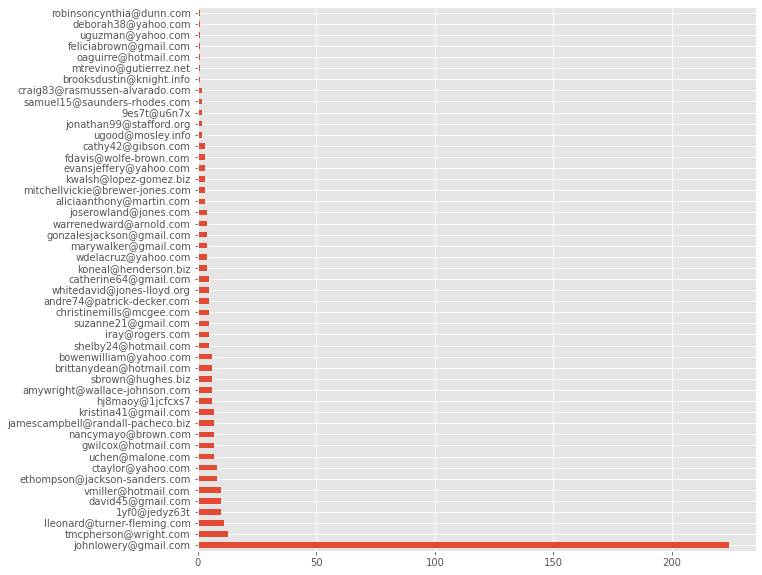

In [ ]:
# 판다스에서 퀵하게 시각화 하는 방법

(
    data_transaction.
    merge(
        data_customer,
        left_on='customerEmail',
        right_on='customerEmail',
        how='left'
    )
    .loc[lambda x : x['Fraud']==True]
    ['customerEmail'].value_counts()
    .plot(kind='barh', figsize=(10, 10))
)

> ##### a) 동일한 개인정보로 여러 계정을 가입했을 경우 이상행동을 의심해볼수 있다

#### (2) Fraud 유저들은 인위적으로 생성된 개인정보를 기입하는지?

In [ ]:
data_customer

,customerEmail,customerPhone,customerDevice,customerIPAddress,customerBillingAddress,No_Transactions,No_Orders,No_Payments,Fraud
0,josephhoward@yahoo.com,400-108-5415,yyeiaxpltf82440jnb3v,8.129.104.40,"5493 Jones Islands\nBrownside, CA 51896",2,2,1,False
1,evansjeffery@yahoo.com,1-788-091-7546,r0jpm7xaeqqa3kr6mzum,219.173.211.202,356 Elizabeth Inlet Suite 120\nPort Joshuabury...,3,3,7,True
2,andersonwilliam@yahoo.com,024.420.0375,4m7h5ipl1shyavt6vv2r,67b7:3db8:67e0:3bea:b9d0:90c1:2b60:b9f0,"8478 Sean Ridges Apt. 441\nDavisberg, PR 72250",5,3,2,False
3,rubenjuarez@yahoo.com,670.664.8168x94985,slovx60t0i558may4ks0,95de:8565:5a66:792c:26e0:6cfb:7d87:11af,"7769 Elizabeth Bridge Apt. 343\nNortonstad, FM...",3,3,1,False
4,uchen@malone.com,1-981-877-0870,j0pd24k5h8dl2fqu0cz4,196.89.235.192,"148 Russell Lodge Apt. 445\nPort Jenniferside,...",7,7,6,True
...,...,...,...,...,...,...,...,...,...
163,mitchellvickie@brewer-jones.com,313-124-3836x3528,ecu7ezz0ue67v3fce1o3,181.90.104.120,"829 Ramirez Dam Suite 648\nGatesview, OR 55669...",3,3,1,True
164,sbrown@hughes.biz,(250)632-6631x02499,xgv918sclaz40qlp2fee,16.166.2.0,"9472 Pacheco Islands Suite 940\nDrewburgh, AZ ...",6,5,3,True
165,johnlowery@gmail.com,635.676.0955x524,969zz9zdj8z4gns4sx5p,f82c:811f:8a02:e2d6:79b:fcaa:42de:570b,"548 Bryant Inlet\nVeronicaside, OK 00522",4,4,2,True
166,ethompson@jackson-sanders.com,962.300.2250,navessqcnmc9csfjn5cj,203.246.172.244,"16953 Jennifer Springs\nKathybury, IL 02095-3215",8,6,6,True


In [ ]:
'string_sample'.split('_')

['string', 'sample']

In [ ]:
data_customer['customerEmail'].str.split('@')

0               [josephhoward, yahoo.com]
1               [evansjeffery, yahoo.com]
2            [andersonwilliam, yahoo.com]
3                [rubenjuarez, yahoo.com]
4                     [uchen, malone.com]
                      ...                
163    [mitchellvickie, brewer-jones.com]
164                  [sbrown, hughes.biz]
165               [johnlowery, gmail.com]
166      [ethompson, jackson-sanders.com]
167            [dawn05, tucker-brown.com]
Name: customerEmail, Length: 168, dtype: object

In [ ]:
data_customer['email_id'] = data_customer['customerEmail'].str.split('@').apply(lambda x : x[0])
data_customer['email_domain'] = data_customer['customerEmail'].str.split('@').apply(lambda x : x[1])

In [ ]:
data_customer['email_id'].tolist()[:5]

['josephhoward', 'evansjeffery', 'andersonwilliam', 'rubenjuarez', 'uchen']

In [ ]:
data_customer['email_domain'].value_counts()

gmail.com            31
yahoo.com            29
hotmail.com          23
wright.com            3
jones.com             2
                     ..
1jcfcxs7              1
levine-harmon.biz     1
reid.com              1
gray.biz              1
tucker-brown.com      1
Name: email_domain, Length: 85, dtype: int64

In [ ]:
(
    data_customer
    .groupby('email_domain')
    ['Fraud'].value_counts()
    .unstack()
    .sort_values(by=True, ascending=False)
    .loc[lambda x : x[True].notnull()]
)

Fraud,False,True
email_domain,,
gmail.com,16.0,15.0
yahoo.com,23.0,6.0
hotmail.com,17.0,6.0
oconnor.com,NaN,1.0
patrick-decker.com,NaN,1.0
randall-pacheco.biz,NaN,1.0
rasmussen-alvarado.com,NaN,1.0
rivera-parker.info,NaN,1.0
rogers.com,NaN,1.0


> ##### b) 일반적으로 알려져있지 않은 도메인의 이메일을 사용하는 경향이 있음

#### (3) Fraud는 동일한 계정에서 반복적으로 일어나는 것인지, 개별 계정에서 산발적으로 일어나는 것인지?

In [ ]:
data_transaction.iloc[:2]

,customerEmail,transactionId,orderId,paymentMethodId,paymentMethodRegistrationFailure,paymentMethodType,paymentMethodProvider,transactionAmount,transactionFailed,orderState
0,josephhoward@yahoo.com,a9lcj51r,vjbdvd,wt07xm68b,1,card,JCB 16 digit,18,0,pending
1,josephhoward@yahoo.com,y4wcv03i,yp6x27,wt07xm68b,1,card,JCB 16 digit,26,0,fulfilled


In [ ]:
data_customer.iloc[:2]

,customerEmail,customerPhone,customerDevice,customerIPAddress,customerBillingAddress,No_Transactions,No_Orders,No_Payments,Fraud,email_id,email_domain
0,josephhoward@yahoo.com,400-108-5415,yyeiaxpltf82440jnb3v,8.129.104.40,"5493 Jones Islands\nBrownside, CA 51896",2,2,1,False,josephhoward,yahoo.com
1,evansjeffery@yahoo.com,1-788-091-7546,r0jpm7xaeqqa3kr6mzum,219.173.211.202,356 Elizabeth Inlet Suite 120\nPort Joshuabury...,3,3,7,True,evansjeffery,yahoo.com


In [ ]:
data_merged = (
    data_transaction
    .merge(data_customer,
         left_on='customerEmail',
         right_on='customerEmail',
         how='left')
)
data_merged

,customerEmail,transactionId,orderId,paymentMethodId,paymentMethodRegistrationFailure,paymentMethodType,paymentMethodProvider,transactionAmount,transactionFailed,orderState,customerPhone,customerDevice,customerIPAddress,customerBillingAddress,No_Transactions,No_Orders,No_Payments,Fraud,email_id,email_domain
0,josephhoward@yahoo.com,a9lcj51r,vjbdvd,wt07xm68b,1,card,JCB 16 digit,18,0,pending,400-108-5415,yyeiaxpltf82440jnb3v,8.129.104.40,"5493 Jones Islands\nBrownside, CA 51896",2,2,1,False,josephhoward,yahoo.com
1,josephhoward@yahoo.com,y4wcv03i,yp6x27,wt07xm68b,1,card,JCB 16 digit,26,0,fulfilled,400-108-5415,yyeiaxpltf82440jnb3v,8.129.104.40,"5493 Jones Islands\nBrownside, CA 51896",2,2,1,False,josephhoward,yahoo.com
2,evansjeffery@yahoo.com,5mi94sfw,nlghpa,41ug157xz,0,bitcoin,American Express,45,0,fulfilled,1-788-091-7546,r0jpm7xaeqqa3kr6mzum,219.173.211.202,356 Elizabeth Inlet Suite 120\nPort Joshuabury...,3,3,7,True,evansjeffery,yahoo.com
3,evansjeffery@yahoo.com,br8ba1nu,uw0eeb,41ug157xz,0,bitcoin,American Express,23,0,fulfilled,1-788-091-7546,r0jpm7xaeqqa3kr6mzum,219.173.211.202,356 Elizabeth Inlet Suite 120\nPort Joshuabury...,3,3,7,True,evansjeffery,yahoo.com
4,evansjeffery@yahoo.com,a33145ss,bn44oh,y3xp697jx,1,bitcoin,VISA 16 digit,43,1,fulfilled,1-788-091-7546,r0jpm7xaeqqa3kr6mzum,219.173.211.202,356 Elizabeth Inlet Suite 120\nPort Joshuabury...,3,3,7,True,evansjeffery,yahoo.com
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
814,dawn05@tucker-brown.com,7yilsi1o,1bubxa,7yen1m1q8,0,card,VISA 13 digit,25,1,fulfilled,(089)703-7360x8848,lu4fgcug8dr0dwbcuui1,132.132.95.33,"130 Kimberly Junctions\nEricmouth, KS 59756-2919",7,5,4,False,dawn05,tucker-brown.com
815,dawn05@tucker-brown.com,c82k5bcv,1bubxa,7yen1m1q8,0,card,VISA 13 digit,25,0,fulfilled,(089)703-7360x8848,lu4fgcug8dr0dwbcuui1,132.132.95.33,"130 Kimberly Junctions\nEricmouth, KS 59756-2919",7,5,4,False,dawn05,tucker-brown.com
816,dawn05@tucker-brown.com,wmh52bns,1bubxa,3zmkegkb8,0,paypal,JCB 15 digit,25,1,fulfilled,(089)703-7360x8848,lu4fgcug8dr0dwbcuui1,132.132.95.33,"130 Kimberly Junctions\nEricmouth, KS 59756-2919",7,5,4,False,dawn05,tucker-brown.com
817,dawn05@tucker-brown.com,xdw33hfp,p0gdbf,3zmkegkb8,0,paypal,JCB 15 digit,19,0,fulfilled,(089)703-7360x8848,lu4fgcug8dr0dwbcuui1,132.132.95.33,"130 Kimberly Junctions\nEricmouth, KS 59756-2919",7,5,4,False,dawn05,tucker-brown.com


In [ ]:
(
    data_merged
    .groupby('customerEmail')
    ['Fraud'].value_counts()
    .unstack()
    .sort_values(by=True, ascending=False)
    .loc[lambda x : x[True].notnull()]
)

Fraud,False,True
customerEmail,,
johnlowery@gmail.com,NaN,224.0
tmcpherson@wright.com,NaN,13.0
lleonard@turner-fleming.com,NaN,11.0
david45@gmail.com,NaN,10.0
vmiller@hotmail.com,NaN,10.0
1yf0@jedyz63t,NaN,10.0
ctaylor@yahoo.com,NaN,8.0
ethompson@jackson-sanders.com,NaN,8.0
uchen@malone.com,NaN,7.0


> ##### c) 일부 계정을 제외하고, 약 10회 미만 사용하고 새 계정을 생성하는 것으로 보임

### · 중요변수 탐색 
---

* 위에는 비즈니스 도메인 고려하여 가설을 세우고 검증한 것이라면, 여기 아래부터는 기계적,통계적으로 변수별 체크하는 과정

In [ ]:
data_merged.iloc[:2].T

,0,1
customerEmail,josephhoward@yahoo.com,josephhoward@yahoo.com
transactionId,a9lcj51r,y4wcv03i
orderId,vjbdvd,yp6x27
paymentMethodId,wt07xm68b,wt07xm68b
paymentMethodRegistrationFailure,1,1
paymentMethodType,card,card
paymentMethodProvider,JCB 16 digit,JCB 16 digit
transactionAmount,18,26
transactionFailed,0,0
orderState,pending,fulfilled


In [ ]:
# unique값 개수를 보고 fraud와 관계를 찾아볼만한 변수를 추림. unique값 개수가 많은 transactionid는 값에 따라 fraud가 다르진 않을 것.
# 반면 paymentMethodType 등은 종류별로 볼 수 있음
(
    pd.DataFrame(
        [(column, data_merged[column].unique().shape[0], data_merged[column].dtype) for column in data_merged.columns], 
        columns=['column_name', 'number_of_unique_values', 'dtype']
    )
    .sort_values(by='number_of_unique_values')
)

,column_name,number_of_unique_values,dtype
17,Fraud,2,bool
4,paymentMethodRegistrationFailure,2,int64
8,transactionFailed,2,int64
9,orderState,3,object
5,paymentMethodType,4,object
15,No_Orders,9,int64
6,paymentMethodProvider,10,object
16,No_Payments,11,int64
14,No_Transactions,13,int64
7,transactionAmount,67,int64


In [ ]:
features_to_investigate = (
    pd.DataFrame(
        [(column, data_merged[column].unique().shape[0]) for column in data_merged.columns], 
        columns=['column_name', 'number_of_unique_values']
    )
    .sort_values(by='number_of_unique_values')
    .loc[lambda x : x['number_of_unique_values'] <100]
    .loc[:, 'column_name']
    .tolist()
)
features_to_investigate

['Fraud',
 'paymentMethodRegistrationFailure',
 'transactionFailed',
 'orderState',
 'paymentMethodType',
 'No_Orders',
 'paymentMethodProvider',
 'No_Payments',
 'No_Transactions',
 'transactionAmount',
 'email_domain']

#### (1) Categorical values

##### a) Distribution check

In [ ]:
(
    data_merged
    .loc[:, features_to_investigate]
    .select_dtypes('object')
)

,orderState,paymentMethodType,paymentMethodProvider,email_domain
0,pending,card,JCB 16 digit,yahoo.com
1,fulfilled,card,JCB 16 digit,yahoo.com
2,fulfilled,bitcoin,American Express,yahoo.com
3,fulfilled,bitcoin,American Express,yahoo.com
4,fulfilled,bitcoin,VISA 16 digit,yahoo.com
...,...,...,...,...
814,fulfilled,card,VISA 13 digit,tucker-brown.com
815,fulfilled,card,VISA 13 digit,tucker-brown.com
816,fulfilled,paypal,JCB 15 digit,tucker-brown.com
817,fulfilled,paypal,JCB 15 digit,tucker-brown.com


In [ ]:
data = (
    pd.concat(
        [
            (
                data_merged
                .loc[:, features_to_investigate]
                .select_dtypes('object')
            ),
            (
                data_merged['Fraud']
            ),
        ],
        axis=1
    )
)
data

,orderState,paymentMethodType,paymentMethodProvider,email_domain,Fraud
0,pending,card,JCB 16 digit,yahoo.com,False
1,fulfilled,card,JCB 16 digit,yahoo.com,False
2,fulfilled,bitcoin,American Express,yahoo.com,True
3,fulfilled,bitcoin,American Express,yahoo.com,True
4,fulfilled,bitcoin,VISA 16 digit,yahoo.com,True
...,...,...,...,...,...
814,fulfilled,card,VISA 13 digit,tucker-brown.com,False
815,fulfilled,card,VISA 13 digit,tucker-brown.com,False
816,fulfilled,paypal,JCB 15 digit,tucker-brown.com,False
817,fulfilled,paypal,JCB 15 digit,tucker-brown.com,False


In [ ]:
for column in data.drop('Fraud', axis=1).columns : 
    data_toplot = (
        data
        .groupby(column)
        ['Fraud']
        .value_counts()
        .to_frame()
        .rename(columns={'Fraud':'Count'})
        .reset_index(drop=False)
        .sort_values(by='Fraud')
    )
    
    if data_toplot[column].unique().shape[0] < 10 : 
        fig = px.bar(data_toplot, x=column, y='Count', color='Fraud', barmode='group')
    else : 
        fig = px.bar(data_toplot, x='Count', y=column, color='Fraud', barmode='group', orientation='h')
        
    fig.update_layout(
        title=dict(
            text='변수 값별 Fraud 분포',
            font=dict(size=25),
        ),
        xaxis_title=dict(
            text=column,
            font=dict(size=25),
        ),
        yaxis_title=dict(
            text="Count",
            font=dict(size=25),
        ),
    )
    fig.show()
    display(data_toplot.sort_values(by=[column, 'Fraud'], ascending=False))

,orderState,Fraud,Count
5,pending,True,12
4,pending,False,32
2,fulfilled,True,393
3,fulfilled,False,298
0,failed,True,48
1,failed,False,36


,paymentMethodType,Fraud,Count
7,paypal,True,15
6,paypal,False,40
4,card,True,371
5,card,False,276
2,bitcoin,True,45
3,bitcoin,False,23
1,apple pay,True,22
0,apple pay,False,27


,paymentMethodProvider,Fraud,Count
18,Voyager,True,53
19,Voyager,False,29
16,VISA 16 digit,True,115
17,VISA 16 digit,False,51
14,VISA 13 digit,True,33
15,VISA 13 digit,False,25
13,Mastercard,True,12
12,Mastercard,False,20
11,Maestro,True,51
10,Maestro,False,53


,email_domain,Fraud,Count
72,young.com,False,5
71,yahoo.com,True,23
70,yahoo.com,False,95
68,wright.com,True,13
69,wright.com,False,6
...,...,...,...
4,brown.com,True,7
3,brewer-jones.com,True,3
2,bell.com,False,6
1,arnold.com,True,4


#### (1) Numerical values
##### a) Correlation

In [ ]:
(
    data_merged
    .loc[:, features_to_investigate]
    .select_dtypes('number')
)

,paymentMethodRegistrationFailure,transactionFailed,No_Orders,No_Payments,No_Transactions,transactionAmount
0,1,0,2,1,2,18
1,1,0,2,1,2,26
2,0,0,3,7,3,45
3,0,0,3,7,3,23
4,1,1,3,7,3,43
...,...,...,...,...,...,...
814,0,1,5,4,7,25
815,0,0,5,4,7,25
816,0,1,5,4,7,25
817,0,0,5,4,7,19


In [ ]:
(
    pd.concat(
        [
            (
                data_merged
                .loc[:, features_to_investigate]
                .select_dtypes('number')
            ),
            (
                data_merged['Fraud']
            ),
        ],
        axis=1
    )
)

,paymentMethodRegistrationFailure,transactionFailed,No_Orders,No_Payments,No_Transactions,transactionAmount,Fraud
0,1,0,2,1,2,18,False
1,1,0,2,1,2,26,False
2,0,0,3,7,3,45,True
3,0,0,3,7,3,23,True
4,1,1,3,7,3,43,True
...,...,...,...,...,...,...,...
814,0,1,5,4,7,25,False
815,0,0,5,4,7,25,False
816,0,1,5,4,7,25,False
817,0,0,5,4,7,19,False


In [ ]:
(
    (
        pd.concat(
            [
                (
                    data_merged
                    .loc[:, features_to_investigate]
                    .select_dtypes('number')
                ),
                (
                    data_merged['Fraud']
                ),
            ],
            axis=1
        )
    )
    .corr()
    .style.background_gradient()
)

,paymentMethodRegistrationFailure,transactionFailed,No_Orders,No_Payments,No_Transactions,transactionAmount,Fraud
paymentMethodRegistrationFailure,1.000000,0.009077,0.147646,-0.022132,0.134989,0.027747,-0.068362
transactionFailed,0.009077,1.000000,-0.001114,-0.036797,0.192300,0.011821,-0.079607
No_Orders,0.147646,-0.001114,1.000000,0.295126,0.776311,0.180719,0.107726
No_Payments,-0.022132,-0.036797,0.295126,1.000000,0.135827,0.054568,0.142165
No_Transactions,0.134989,0.192300,0.776311,0.135827,1.000000,0.073317,-0.062605
transactionAmount,0.027747,0.011821,0.180719,0.054568,0.073317,1.000000,0.279281
Fraud,-0.068362,-0.079607,0.107726,0.142165,-0.062605,0.279281,1.000000


# **🥇Session 3**  
**┗ 이상 탐지 모델링**  
---

### · 모델링을 위한 데이터 준비
---
* 모델링을 수행하기 위해 Feature (X)와 예측하고자하는 값인 Y로 데이터를 나눔
* 학습과 예측을 위한 Train / Test set 분할

In [ ]:
data_merged.iloc[:4].T

,0,1,2,3
customerEmail,josephhoward@yahoo.com,josephhoward@yahoo.com,evansjeffery@yahoo.com,evansjeffery@yahoo.com
transactionId,a9lcj51r,y4wcv03i,5mi94sfw,br8ba1nu
orderId,vjbdvd,yp6x27,nlghpa,uw0eeb
paymentMethodId,wt07xm68b,wt07xm68b,41ug157xz,41ug157xz
paymentMethodRegistrationFailure,1,1,0,0
paymentMethodType,card,card,bitcoin,bitcoin
paymentMethodProvider,JCB 16 digit,JCB 16 digit,American Express,American Express
transactionAmount,18,26,45,23
transactionFailed,0,0,0,0
orderState,pending,fulfilled,fulfilled,fulfilled


In [ ]:
data_merged.iloc[:4].loc[:, features_to_investigate].T 

,0,1,2,3
Fraud,False,False,True,True
paymentMethodRegistrationFailure,1,1,0,0
transactionFailed,0,0,0,0
orderState,pending,fulfilled,fulfilled,fulfilled
paymentMethodType,card,card,bitcoin,bitcoin
No_Orders,2,2,3,3
paymentMethodProvider,JCB 16 digit,JCB 16 digit,American Express,American Express
No_Payments,1,1,7,7
No_Transactions,2,2,3,3
transactionAmount,18,26,45,23


In [ ]:
dataset = data_merged.loc[:, features_to_investigate]
dataset

,Fraud,paymentMethodRegistrationFailure,transactionFailed,orderState,paymentMethodType,No_Orders,paymentMethodProvider,No_Payments,No_Transactions,transactionAmount,email_domain
0,False,1,0,pending,card,2,JCB 16 digit,1,2,18,yahoo.com
1,False,1,0,fulfilled,card,2,JCB 16 digit,1,2,26,yahoo.com
2,True,0,0,fulfilled,bitcoin,3,American Express,7,3,45,yahoo.com
3,True,0,0,fulfilled,bitcoin,3,American Express,7,3,23,yahoo.com
4,True,1,1,fulfilled,bitcoin,3,VISA 16 digit,7,3,43,yahoo.com
...,...,...,...,...,...,...,...,...,...,...,...
814,False,0,1,fulfilled,card,5,VISA 13 digit,4,7,25,tucker-brown.com
815,False,0,0,fulfilled,card,5,VISA 13 digit,4,7,25,tucker-brown.com
816,False,0,1,fulfilled,paypal,5,JCB 15 digit,4,7,25,tucker-brown.com
817,False,0,0,fulfilled,paypal,5,JCB 15 digit,4,7,19,tucker-brown.com


In [ ]:
categorical_features = (
    dataset
    .loc[:, features_to_ investigate]
    .drop('Fraud', axis=1)
    .select_dtypes('object')
    .columns
    .tolist()
)
numerical_features = (
    dataset
    .loc[:, features_to_investigate]
    .drop('Fraud', axis=1)
    .select_dtypes('number')
    .columns
    .tolist()
)
target_value='Fraud'

In [ ]:
categorical_features

['orderState', 'paymentMethodType', 'paymentMethodProvider', 'email_domain']

In [ ]:
numerical_features

['paymentMethodRegistrationFailure',
 'transactionFailed',
 'No_Orders',
 'No_Payments',
 'No_Transactions',
 'transactionAmount']

In [ ]:
target_value

'Fraud'

### · 모델 학습 및 평가
---
* 모델을 학습하고 예측을 수행하여 성능을 평가
* 참고 자료
    - [Pycaret:Classification](https://pycaret.readthedocs.io/en/stable/api/classification.html)
    
    - Pycaret은 ML Workflow를 자동화하는 오픈소스 라이브러리
      Classification, Regression, Clustering 등의 Task에서 사용하는 여러
      모델들을 동일한 환경에서 한 번에 실행할 수 있도록 자동화.
      여러 모델을 비교할 수 있으며 각 모델별로 튜닝 가능.

    - 모델 학습 및 검증/평가, 해석, 변수중요도 파악, 모델 저장 및 로드 등 모두 제공

#### 1) 모델 학습

![](figures/16_5.png)

- 과거에는 Scikit-learn, Pytorch등의 패키지등을 통해 모델과 전/후처리 파이프라인들을 개별적으로 설정하여 모델 비교를 위한 실험 코드를 작성
- 여러 프로젝트에서 동일한 코드를 반복적으로 작성/사용하게 되며 이로 인한 효율이 떨어짐
- 이미 알려지고 사용되고 있는 모델들을 한꺼번에 실험할수 있는 인터페이스가 필요 -> `Pycaret` 활용하여 빠르게 여러 모델간의 성능 비교가 가능

In [ ]:
!pip install pycaret==3.0.0rc4

In [ ]:
!pip install pycaret[full]

In [ ]:
from pycaret.classification import ClassificationExperiment

experiment_name = 'chapter_16'
exp = ClassificationExperiment() # 분류모델 실험 세팅을 위한 객체

- 실험 수행

In [ ]:
exp.setup(
    data=dataset, # dataset에는 input feature와 target이 모두 들어가있어야 함
    target=target_value,
    train_size=0.8,
    categorical_features=categorical_features, # 해당 변수명 문자열 리스트
    numeric_features=numerical_features, # 해당 변수명 문자열 리스트
    normalize=True,
    fold_strategy='kfold',
    fold_shuffle=True,
    fold=10,
    experiment_name=experiment_name
)

# 이외 차원축소(pca), feature selection 등 다양한 옵션 존재. document 참고.

,Description,Value
0,Session id,1088
1,Target,Fraud
2,Target type,Binary
3,Original data shape,"(819, 11)"
4,Transformed data shape,"(819, 16)"
5,Transformed train set shape,"(655, 16)"
6,Transformed test set shape,"(164, 16)"
7,Numeric features,6
8,Categorical features,4
9,Preprocess,True


- 실험 결과 확인
    - AUC, Recall, Prec.(Precision) 확인

In [ ]:
!pip install xgboost
!pip install catboost

In [ ]:
models = exp.compare_models(sort='AUC', n_select=5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9297,0.9809,0.9470,0.9296,0.9371,0.8567,0.8594,0.3080
rf,Random Forest Classifier,0.8946,0.9623,0.9482,0.8728,0.9081,0.7825,0.7881,0.2030
ada,Ada Boost Classifier,0.8397,0.9278,0.9424,0.8028,0.8659,0.6661,0.6824,0.1450
lr,Logistic Regression,0.8687,0.9277,0.9018,0.8687,0.8837,0.7310,0.7344,1.4770
lda,Linear Discriminant Analysis,0.8626,0.9258,0.8992,0.8602,0.8777,0.7194,0.7237,0.2020
knn,K Neighbors Classifier,0.8445,0.9155,0.8582,0.8567,0.8562,0.6850,0.6875,0.4120
nb,Naive Bayes,0.8429,0.9095,0.8659,0.8501,0.8569,0.6797,0.6819,0.0900
lightgbm,Light Gradient Boosting Machine,0.8672,0.9055,0.9243,0.8518,0.8853,0.7263,0.7321,0.2750
gbc,Gradient Boosting Classifier,0.8733,0.9045,0.9292,0.8556,0.8896,0.7397,0.7456,0.1700
qda,Quadratic Discriminant Analysis,0.8276,0.8948,0.8302,0.8529,0.8399,0.6495,0.6524,0.0830


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

#### 2) 모델 평가

- Extra Tress Classifier

![](figures/16_7.png)

In [ ]:
model = models[0]

##### a) Confusion matrix
![](figures/16_3.png)

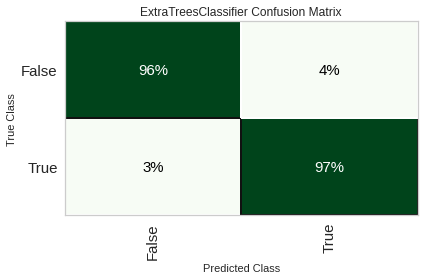

In [ ]:
exp.plot_model(model, plot='confusion_matrix', plot_kwargs={'percent':True})

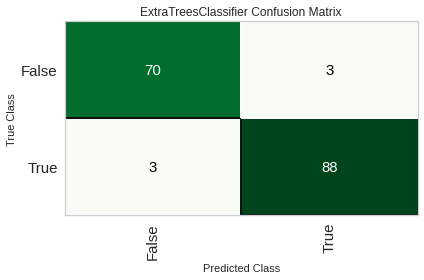

In [ ]:
exp.plot_model(model, plot='confusion_matrix')

##### b) AUROC

![](figures/16_2.png)
![](figures/16_4.png)
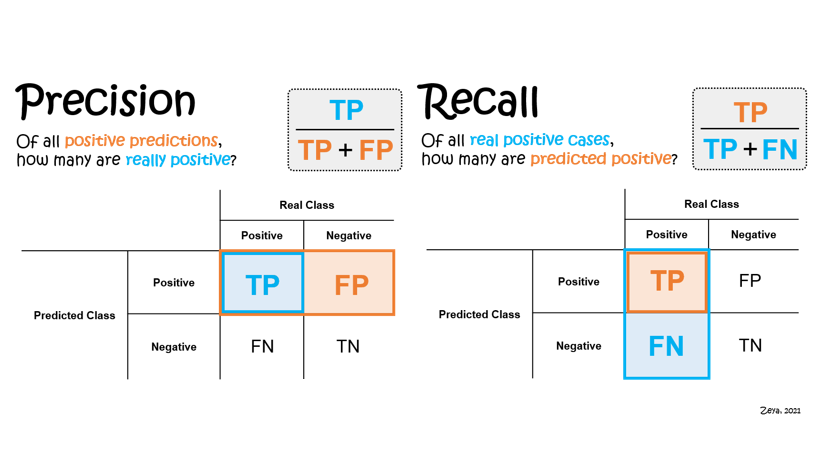

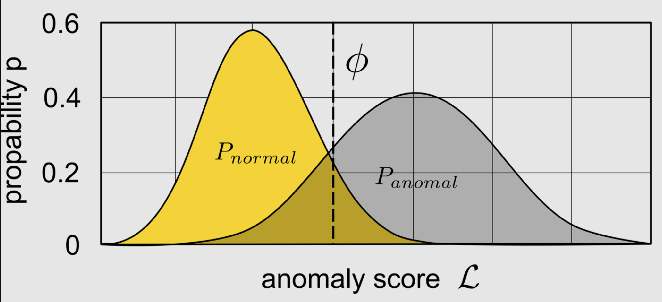

* ROC 커브 설명
: https://angeloyeo.github.io/2020/08/05/ROC.html 

1 : Fraud
0 : Normal

Threshold = 0.5   
이 유저는 0.4 -> Normal에 가까움 -> 0    

Threshold = 0.8   
이 유저는 0.7 -> Fraud에 가까움 -> 0   

어디서부터 Fraud? 

왼쪽위에 선이 쏠려있을수록 좋은 분류기 성능

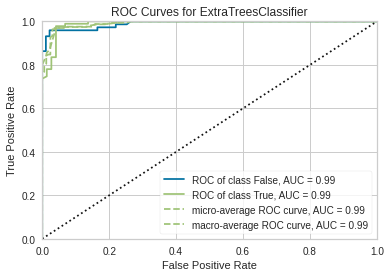

In [ ]:
exp.plot_model(model, plot='auc')

#### 2) 모델 해석

##### a) 모델 Threshold

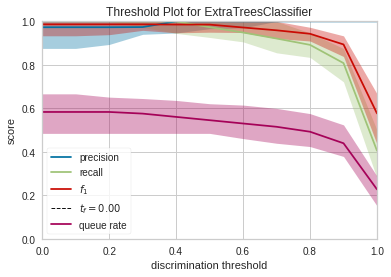

In [ ]:
exp.plot_model(model, plot='threshold')

##### b) 모델 Training history

* 학습이 제대로 진행되지 않았는지 체크. 학습이 잘 되지 않아 성능이 안나오면 후속조치가 필요

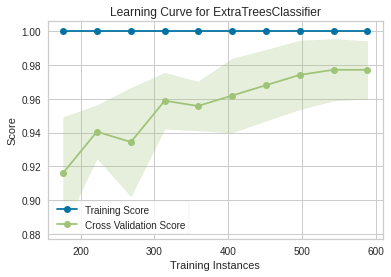

In [ ]:
exp.plot_model(model, plot='learning')

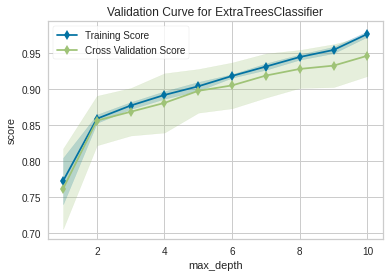

In [ ]:
exp.plot_model(model, plot='vc')

##### c) 모델 Decision boundary 시각화
![](figures/16_6.png)

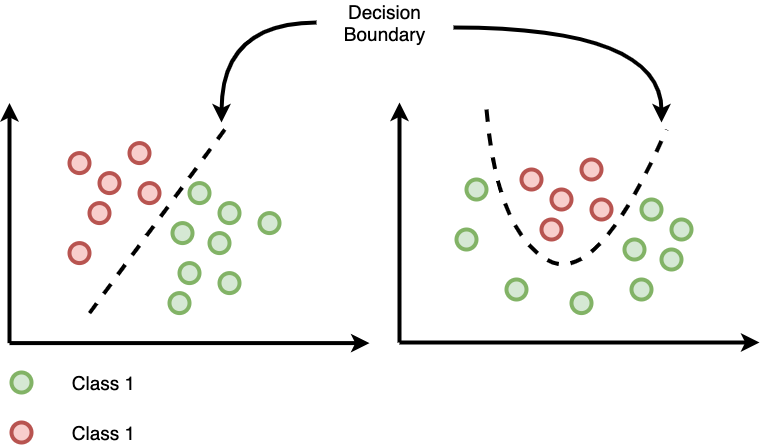

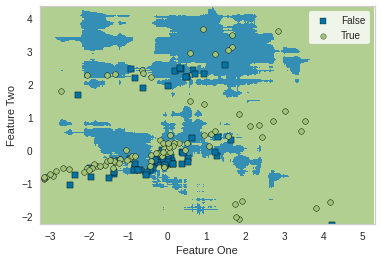

In [ ]:
exp.plot_model(model, plot='boundary')

### · 중요 변수 파악
---
* Feature importance 분석을 통한 중요변수 파악
(현업에 보고할 땐 변수중요도 보다는 앞의 가설검증 및 EDA 내용 위주로 중요성 설명)

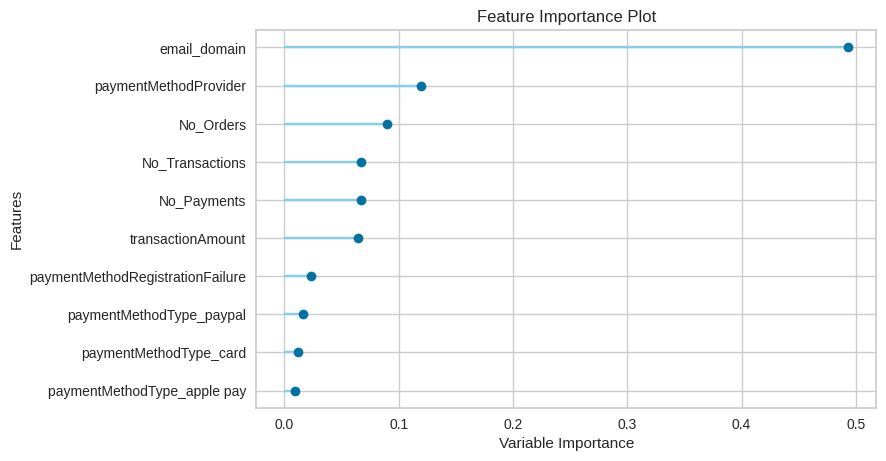

In [ ]:
exp.plot_model(model, plot='feature')

- RFE (Recursive feature elimiation)

* 변수 2개일 때 성능이 가장 좋았음

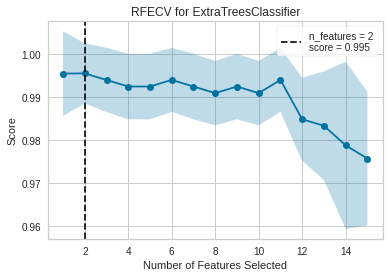

In [ ]:
exp.plot_model(model, plot='rfe')


### · 모델 확인
---
* 실험으로부터 사용할 수 있는 모델을 불러오기

In [ ]:
model

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_samples_leaf=1,
                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                     n_estimators=100, n_jobs=-1, oob_score=False,
                     random_state=1985, verbose=0, warm_start=False)

In [ ]:
model_finalized = exp.finalize_model(model)

In [ ]:
x_test = exp.X_test
x_test

,paymentMethodRegistrationFailure,transactionFailed,orderState,paymentMethodType,No_Orders,paymentMethodProvider,No_Payments,No_Transactions,transactionAmount,email_domain
655,0,0,fulfilled,apple pay,4,American Express,3,6,41,yahoo.com
656,0,0,fulfilled,card,4,JCB 16 digit,2,4,27,gmail.com
657,0,0,fulfilled,card,0,VISA 16 digit,0,0,42,gmail.com
658,0,0,pending,card,4,Voyager,2,6,34,bell.com
659,1,0,fulfilled,card,4,Diners Club / Carte Blanche,2,5,36,hotmail.com
...,...,...,...,...,...,...,...,...,...,...
814,0,0,fulfilled,card,3,Diners Club / Carte Blanche,3,3,17,wolfe-brown.com
815,0,0,fulfilled,card,4,American Express,1,7,44,yahoo.com
816,0,0,fulfilled,card,3,Voyager,1,3,26,yahoo.com
817,0,0,fulfilled,paypal,4,JCB 16 digit,2,4,46,gmail.com


In [ ]:
y_test = exp.y_test
y_test

655    False
656     True
657     True
658    False
659     True
       ...  
814     True
815    False
816    False
817     True
818    False
Name: Fraud, Length: 164, dtype: bool

In [ ]:
from sklearn.metrics import roc_auc_score

yhat_test = model_finalized.predict(x_test)
roc_auc_score(yhat_test, y_test)

0.9945652173913043


### · 모델 Save and Read
---
* 최종 모델을 저장 및 다시 불러오기

In [ ]:
exp.save_model(
    model=model_finalized, 
    model_name=f'model_{experiment_name}_v1'
)

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=/tmp/joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['paymentMethodRegistrationFailure',
                                              'transactionFailed', 'No_Orders',
                                              'No_Payments', 'No_Transactions',
                                              'transactionAmount'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               missing_values=nan,
                                                               strategy='mean',
                                                               verbose=0...
                  ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0,
     

In [ ]:
model_loaded = exp.load_model(
    model_name=f'model_{experiment_name}_v1'
)

Transformation Pipeline and Model Successfully Loaded


In [ ]:
model_loaded.predict(x_test)

array([False,  True,  True, False,  True, False, False, False,  True,
       False,  True,  True,  True, False,  True, False,  True,  True,
       False, False,  True, False,  True,  True,  True,  True, False,
       False, False, False, False,  True, False,  True,  True, False,
        True,  True, False,  True,  True, False, False,  True, False,
       False, False,  True,  True,  True, False,  True,  True,  True,
       False, False,  True,  True,  True,  True,  True,  True, False,
       False,  True,  True,  True,  True, False, False,  True,  True,
        True,  True, False,  True, False,  True, False,  True,  True,
        True,  True, False,  True, False,  True,  True, False, False,
       False,  True, False,  True, False,  True, False,  True, False,
        True,  True,  True, False,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True, False,  True, False,  True, False, False,  True,  True,
       False, False,

* 더 상세한 pycaret 사용기 : https://sthsb.tistory.com/31
